# Gradient Boosting

Gradient boosting is like adaboost meaning it It builds the model in a stage-wise fashion, except that the aim is not to tweek the weight. Rather, a predictor is fit to the residual errors of the previous predictor. For example,

```
m1 = model.fit(X_train, y_train)
y1 = y - m1.predict(X_test)

m2 = model.fit(X_train, y1)
y2 = y1 - m1.predict(X_test)

m3 = model.fit(X_train, y2)
y3 = y2 - m1.predict(X_test)

...

# and so on
```


## Shrinkage

There is a technique with gradient boosted decision trees known as shrinkage. Its been empirically shown that adjusting for a smaller learning rate yeilds strong improvements to the overall model. However, it comes at the prices of increasing the number models required to have good performance and hence the linked computational complexity.


**Let's demonstrate gradient boosting on a toy example**

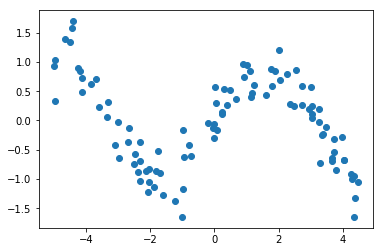

In [22]:
import matplotlib.pyplot as plt
from myutils.datasets import noisy_func


X, y = noisy_func(lambda x: np.sin(x), (-5, 5), .01, 100, .3)
plt.scatter(X, y)
plt.show()

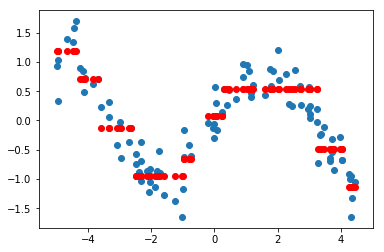

In [23]:
from sklearn.tree import DecisionTreeRegressor


X = X.reshape(-1, 1)
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

y_pred = sum(tree.predict(X) for tree in (tree_reg1, 
                                          tree_reg2, 
                                          tree_reg3))

plt.scatter(X, y)
plt.scatter(X, y_pred, c='red')
plt.show()

**What is the effect of continuously fitting residuals?**

<img src="../../assets/6-model-ensemble-and-improvement-techniques/gradient_boosting1.png" alt="gradient_boosting1" style="width: 400px;"/>

Continuously fitting residuals does not nessessarily make them smaller like in the illustration above, but its the effect it has is fitting more and more to the patterns of error that have been previously attributed. Over several models, you obtain both underestimates and overestimates that relate to the same model. 

Think about what happens when you fit the first model. You get some error. Now imagine refitting against the residuals of that model. If you combine the predictions of both models, what you get is the original prediction, and then the prediction that adjusts for the error in the previous model.

With enought gradient boosts the model will grow to eventually overfit to the data. Lets demonstrate this.

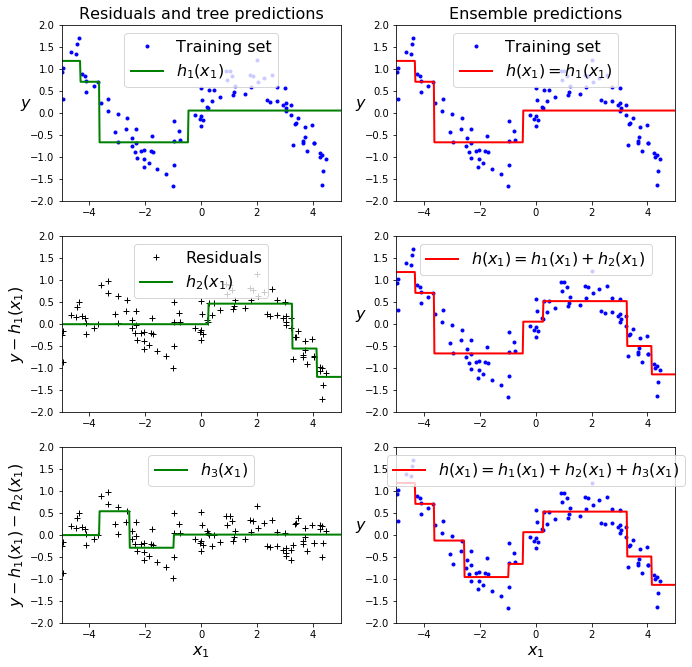

In [28]:
import numpy as np


def plot_predictions(regressors, X, y, axes=[-5, 5, -2, 2], label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)

plot_predictions([tree_reg1], X, y, label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

The first column represents the regressors on their own. The column on the right represents the regressors predictions progressively added together.

Now lets repeat this process a couple more times and see what happens.

Text(0.5, 1.0, 'GradientBoostingRegressor with 200 estimators and learning rate of 0.1')

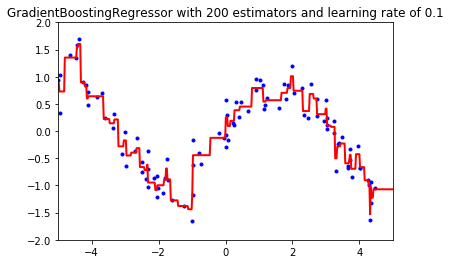

In [29]:
from sklearn.ensemble import GradientBoostingRegressor


gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)
plot_predictions([gbrt_slow], X, y)
plt.title("GradientBoostingRegressor with 200 estimators")

As expected, you get an obvious case of overfitting. 

**What are some strategies we can use to reduce overfitting?**

One way is to use `GridSearch`, but as an individual model, there are more efficient ways about doing it. The is not as efficient, as it involves a brute force iteration through all the previous estimators in the the model (returned as an iterator from `staged_predict`), and then just select the best one.

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# initialize a model with 120 estimators
X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=150)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

# select the index that returned the lowest error (which is convientiently also the number of estimators)
bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=43, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In addition to the predicted curve, lets plot the error rate as a function on the number of estimators. We'll notice something characteristic.

Text(0.5, 1.0, 'GradientBoostingRegressor with 43 estimators')

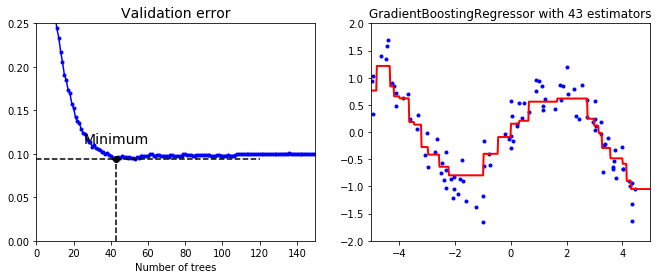

In [37]:
plt.figure(figsize=(11, 4))

min_error = np.min(errors)
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 150, 0, 0.25])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y)
plt.title(f"GradientBoostingRegressor with {bst_n_estimators} estimators")

### Early Stopping with `warm_start`

The observation here is that there tends to be one local minimum. So now, rather than exploring an entire (specified) number of estimators, is there is a way to immediately return on the instance of reaching a minimum.

Yes. SKlearn employs parameter `warm_start` just for this reason. With this parameter, sklearn maintains previous estimators in memory so that it become possible to go back to any previous state.

In [38]:
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 150):
    # change controlled parameter
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    # if the error increases on more than 5 occasions (not nessessarily continiously)
    # then avoid retraining on the remaining estimators
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break
            
# at this point, we have a model set with the optiminal number of estimators based on early stopping

## Stochastic Gradient Boosting

There is an additional parameter supported called `sub_sample`, that allows each model to randomly sample on some relative portion on the training set every time. The main trade off here the complexity. The idea here is that we are relying on only some _fixed_ proportion of the data to make the incremental improvements to the data over time.

In effect, this is like making our data smaller, but approximately maintaining the advantages as if the data was large.


## Other 

Other `loss` functions can be used.